1. Предобработка

In [1]:
import numpy as np
import pandas as pd
import torch

In [2]:
train_data = pd.read_csv('train.csv')
train_data

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ
...,...,...
29995,29996.opus,ЬДТРЭ 9М6М
29996,29997.opus,ЬКТ1 ШЭЪ
29997,29998.opus,ЫВЙЗБЯН7К
29998,29999.opus,ФЯДШ3Т#


In [ ]:
all_chars = ''.join(train_data['message'].astype(str))

unique_chars = sorted(set(all_chars))

print("Уникальные символы:", unique_chars)
print("Количество уникальных символов:", len(unique_chars))

Уникальные символы: [' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
Количество уникальных символов: 44


In [ ]:
chars = set()
for message in train_data['message']:
    chars.update(message)
char_to_idx = {c: i+1 for i, c in enumerate(sorted(chars))}  # 0 зарезервирован для padding
idx_to_char = {i: c for c, i in char_to_idx.items()}
output_dim = len(char_to_idx) + 1  # +1 для blank символа CTC

char_to_idx, idx_to_char,output_dim

({' ': 1,
  '#': 2,
  '0': 3,
  '1': 4,
  '2': 5,
  '3': 6,
  '4': 7,
  '5': 8,
  '6': 9,
  '7': 10,
  '8': 11,
  '9': 12,
  'А': 13,
  'Б': 14,
  'В': 15,
  'Г': 16,
  'Д': 17,
  'Е': 18,
  'Ж': 19,
  'З': 20,
  'И': 21,
  'Й': 22,
  'К': 23,
  'Л': 24,
  'М': 25,
  'Н': 26,
  'О': 27,
  'П': 28,
  'Р': 29,
  'С': 30,
  'Т': 31,
  'У': 32,
  'Ф': 33,
  'Х': 34,
  'Ц': 35,
  'Ч': 36,
  'Ш': 37,
  'Щ': 38,
  'Ъ': 39,
  'Ы': 40,
  'Ь': 41,
  'Э': 42,
  'Ю': 43,
  'Я': 44},
 {1: ' ',
  2: '#',
  3: '0',
  4: '1',
  5: '2',
  6: '3',
  7: '4',
  8: '5',
  9: '6',
  10: '7',
  11: '8',
  12: '9',
  13: 'А',
  14: 'Б',
  15: 'В',
  16: 'Г',
  17: 'Д',
  18: 'Е',
  19: 'Ж',
  20: 'З',
  21: 'И',
  22: 'Й',
  23: 'К',
  24: 'Л',
  25: 'М',
  26: 'Н',
  27: 'О',
  28: 'П',
  29: 'Р',
  30: 'С',
  31: 'Т',
  32: 'У',
  33: 'Ф',
  34: 'Х',
  35: 'Ц',
  36: 'Ч',
  37: 'Ш',
  38: 'Щ',
  39: 'Ъ',
  40: 'Ы',
  41: 'Ь',
  42: 'Э',
  43: 'Ю',
  44: 'Я'},
 45)

In [ ]:
from pathlib import Path
import os
import librosa

current_dir = Path(os.getcwd()) / 'morse_dataset' / 'morse_dataset'


audio_file = current_dir / '44.opus'

try:
    signal, sr = librosa.load(str(audio_file), sr=8000)
    print("Файл загружен")
except Exception as e:
    print(f"Ошибка: {e}")

signal.shape

Файл успешно загружен!


(64000,)

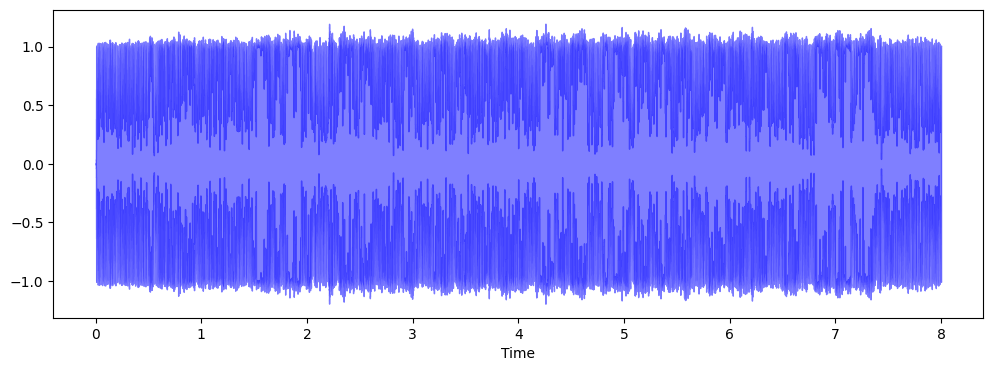

In [4]:
import matplotlib.pyplot as plt
import librosa.display as ld
plt.figure(figsize=(12,4))
ld.waveshow(signal, sr=sr, color='b', alpha=0.5)

**- Удаление шума(Решение задачи оптимизации)**
min||x-xc||2 + aR(x) -> градиент

[-1.12100187e-05 -2.71471917e-04 -6.23324648e-04 ...  3.46614903e-01
  3.86442589e-01  3.86985537e-01]
[ 2.5195009e-03  5.5052084e-04 -3.0684555e-03 ...  9.2075467e-01
  7.7889383e-01  3.9248869e-01]


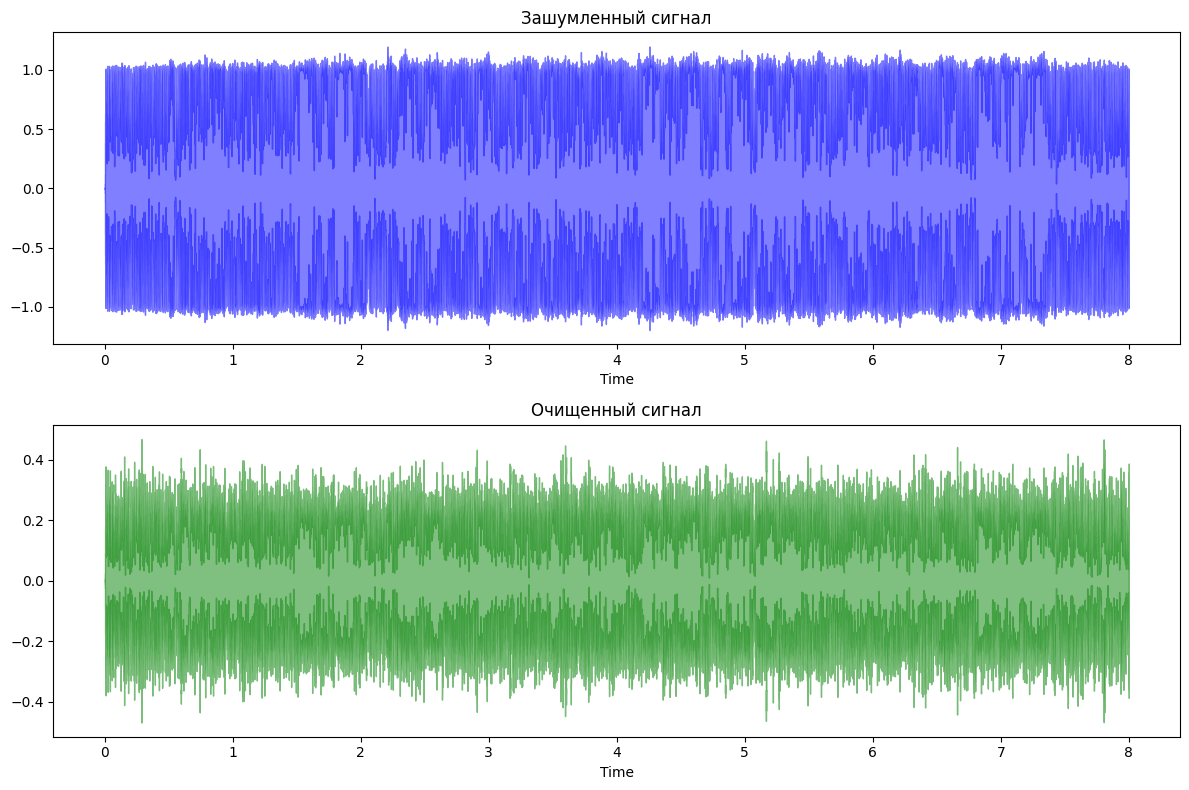

In [5]:
import numpy as np
from scipy.optimize import minimize
from scipy.sparse import diags
from scipy.sparse.linalg import splu

def purified_signal_matrix(x_noisy:np.array, lambda_reg: int):
    """
    Функция для удаления шума из сигнала через оптимизацию (матричная форма)
    
    Параметры:
    x_noisy - зашумленный сигнал
    lambda_reg - параметр регуляризации > 0
    
    Возвращает:
    x_denoised - очищенный от шума сигнал
    """
    n = len(x_noisy)
    def loss_function(x):
        # Основной член: ||x - x_noisy||2(Вторая норма)
        x_nom = x - x_noisy
        second_norm = x_nom  @ x_nom.T
        
        # Регуляризационный член: R(x)*λ = λ *  sum(xi+1 - xi)
        reg = lambda_reg * np.sum(np.diff(x)**2)
        
        return second_norm + reg
    
    def gradient(x):
        # Градиент основного члена: 
        main_grad = 2 * (x - x_noisy)
        
        # Градиент регуляризатора: 
        reg_grad = np.zeros(n)
        reg_grad[:-1] += 2 * lambda_reg * (x[:-1] - x[1:])
        reg_grad[1:] += 2 * lambda_reg * (x[1:] - x[:-1])
        return main_grad + reg_grad
    
    # Начальное приближение
    x0 = x_noisy.copy()
    
    # Минимизация с использованием градиента
    res = minimize(loss_function, x0, method='L-BFGS-B', jac=gradient)
    
    return res.x

purified_signal = purified_signal_matrix(signal,lambda_reg=10)
print(purified_signal)
print(signal)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
ld.waveshow(signal, sr=sr, color='b', alpha=0.5)
plt.title('Зашумленный сигнал')

plt.subplot(2, 1, 2)
ld.waveshow(purified_signal, sr=sr, color='g', alpha=0.5)
plt.title('Очищенный сигнал')

plt.tight_layout()
plt.show()


In [95]:
import IPython
display(IPython.display.Audio(signal, rate = sr))

In [96]:
import IPython
display(IPython.display.Audio(purified_signal, rate = sr))

**Получение Mel-frequency cepstral coefficients(MEL spectogram)**
По сути это главное что нужно для обучения

In [99]:
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc = 40, hop_length=512)
mfccs

array([[ 63.62691   ,  97.001625  , 104.256256  , ...,  97.89099   ,
         79.66866   ,  43.40029   ],
       [ 84.94368   ,  85.12259   ,  84.64111   , ...,  78.65256   ,
         88.116234  ,  93.21279   ],
       [-54.34955   , -56.44793   , -55.7941    , ..., -57.13366   ,
        -57.138573  , -52.302383  ],
       ...,
       [ -4.088044  ,  -1.0239931 ,   2.263001  , ...,   2.8389733 ,
         -1.82573   ,  -2.5150127 ],
       [  0.9644664 ,   0.87222624,  -2.9361868 , ...,  -1.5241978 ,
          2.3021512 ,   3.8404741 ],
       [  3.7559319 ,   1.413868  ,  -2.9510157 , ...,   1.1057578 ,
          1.9566541 ,   3.7461    ]], dtype=float32)

In [100]:
[40, len(signal)//512+1]

[40, 126]

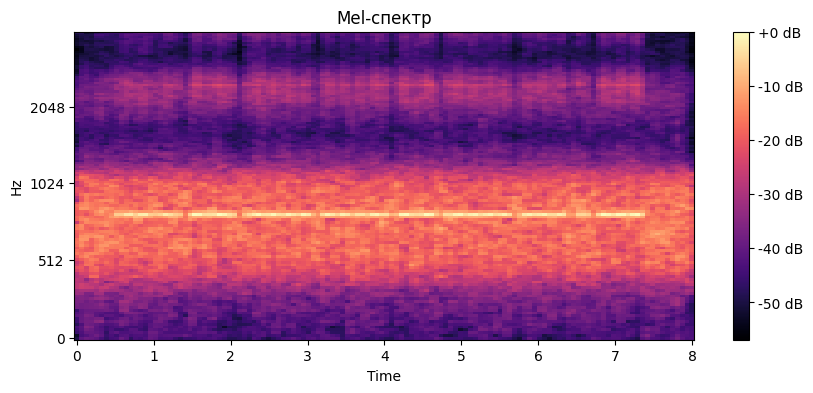

ValueError: not enough values to unpack (expected 3, got 2)

In [109]:
mel = librosa.feature.melspectrogram(y=signal, sr = sr,
                                        	hop_length =512)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектр')
plt.show()
_, n_mels, n_steps = mel_db.shape

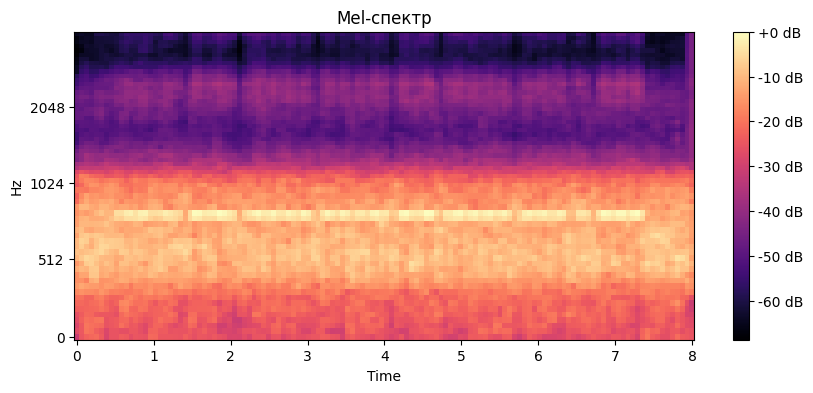

(64, 126)

In [6]:
# Построение Mel-спектрограммы
mel = librosa.feature.melspectrogram(y=purified_signal, sr=sr, n_mels=64)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектр')
plt.show()

mel_db.shape

Далее нужна спектратьльная аугментация для улучщения обобщающей спосоьбности (Frequency mask,Time mask)
Временная маска - замена случайных отрезков времени на 0
Частотая маска - замена случайных отрезков частот на 0
Эти функции есть torchaudio.transforms.

In [9]:
spec_tensor = torch.from_numpy(mel_db).unsqueeze(0)
spec_tensor.shape

torch.Size([1, 64, 126])

torch.Size([64, 126]) 64-число частот по мел, 126 - число шагов по вермени

In [ ]:
import torchaudio
time_masking = torchaudio.transforms.TimeMasking(time_mask_param=5) 
freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=5)

augment = time_masking(spec_tensor)
augment = freq_masking(augment)

augment_np = augment.numpy()

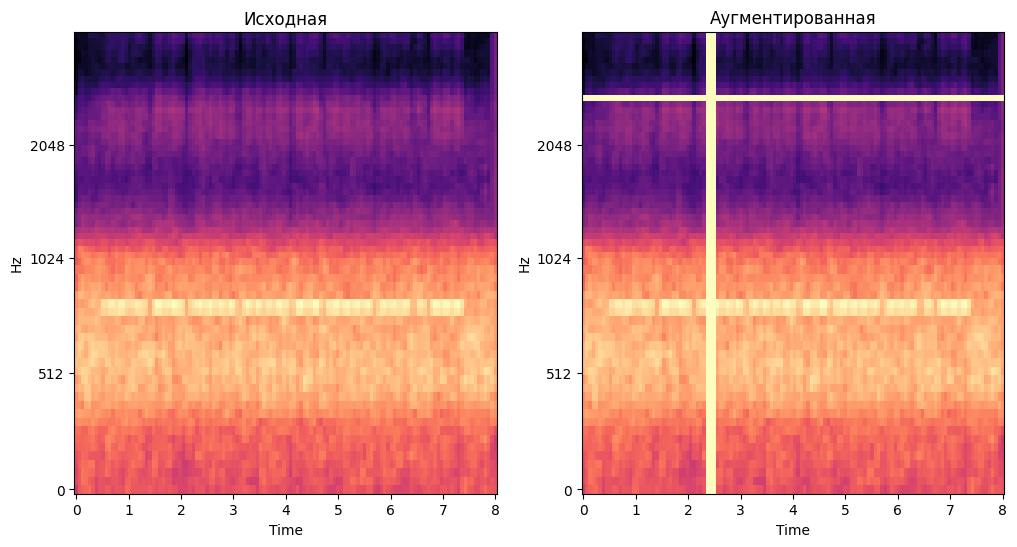

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.title("Исходная")

plt.subplot(1, 2, 2)
librosa.display.specshow(augment_np, sr=sr, x_axis='time', y_axis='mel')
plt.title("Аугментированная")
plt.show()

-----------------

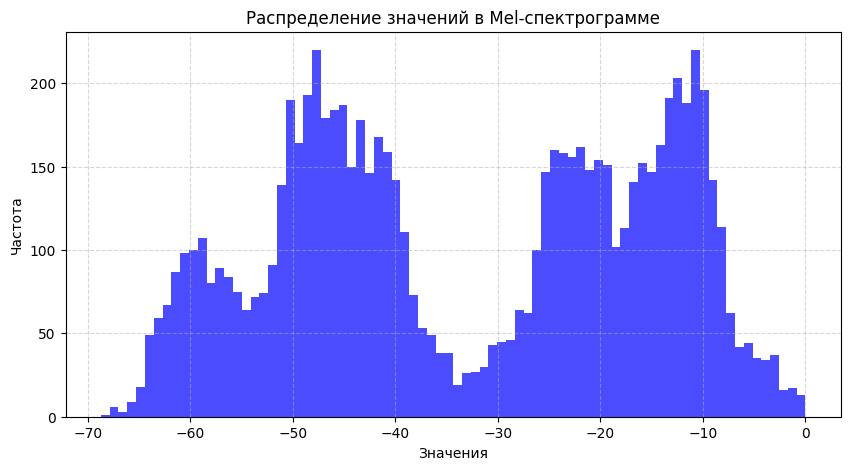

In [145]:
# проверка распределения mel_db
import torch
values = mel_db.flatten()
plt.figure(figsize=(10, 5))
plt.hist(values, bins=80, color='blue', alpha=0.7)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений в Mel-спектрограмме')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

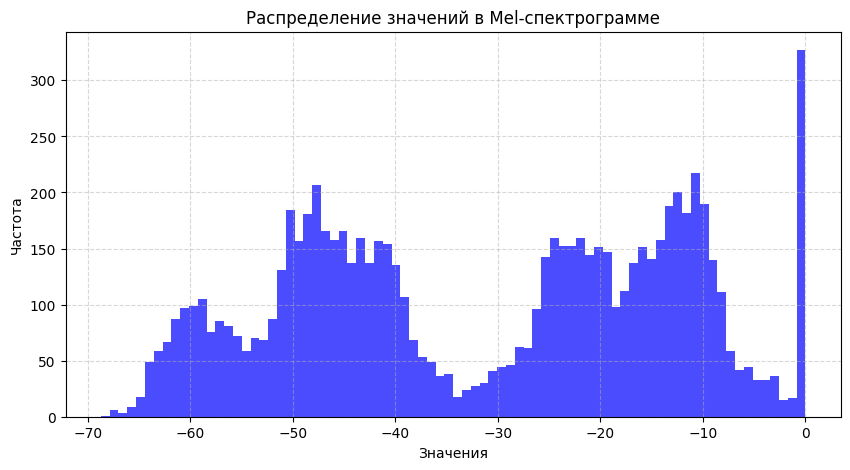

In [ ]:
import torch
values = augment_np.flatten()
plt.figure(figsize=(10, 5))
plt.hist(values, bins=80, color='blue', alpha=0.7)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений в Mel-спектрограмме')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

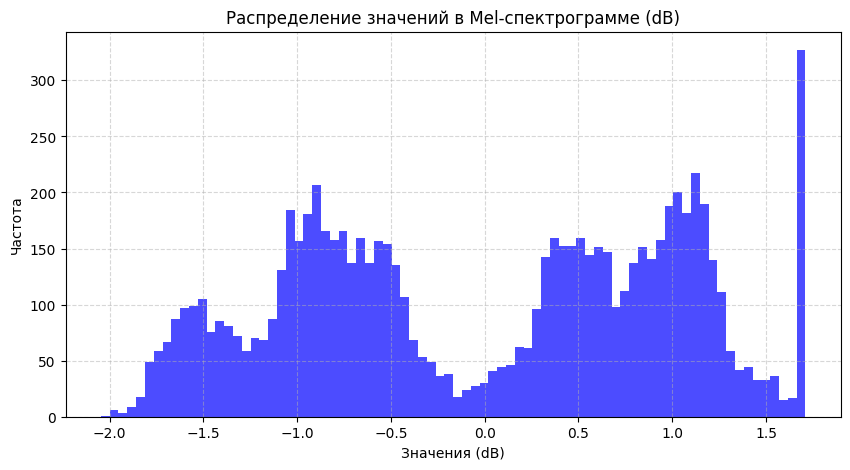

torch.Size([64, 126])

In [ ]:
# Стандартизация
norm = (augment_np - augment_np.mean()) / augment_np.std()
values = norm.flatten()

plt.figure(figsize=(10, 5))
plt.hist(values, bins=80, color='blue', alpha=0.7)
plt.xlabel('Значения (dB)')
plt.ylabel('Частота')
plt.title('Распределение значений в Mel-спектрограмме (dB)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

torch.FloatTensor(norm).shape

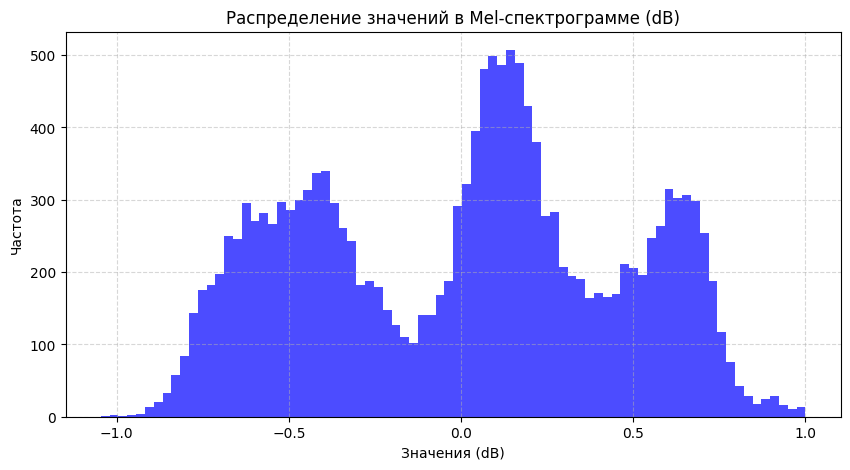

In [12]:
# нормализация (нужно для перевода в диапазон значений [0,1])
norm = (mel_db - mel_db.mean()) / (mel_db.max() - mel_db.mean())
values = norm.flatten()

plt.figure(figsize=(10, 5))
plt.hist(values, bins=80, color='blue', alpha=0.7)
plt.xlabel('Значения (dB)')
plt.ylabel('Частота')
plt.title('Распределение значений в Mel-спектрограмме (dB)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

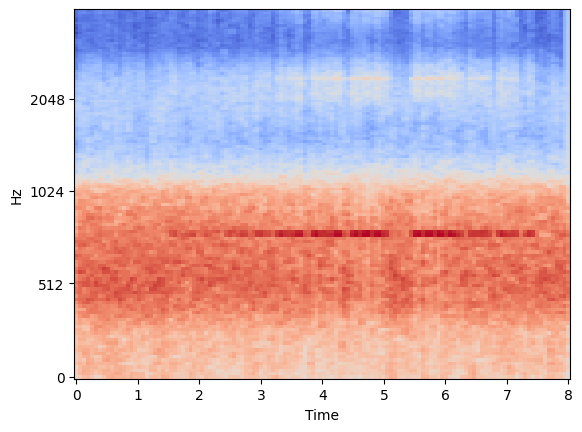

In [30]:
#plt.figure(figsize=(10, 4))
librosa.display.specshow(norm, sr=sr, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-спектр')
# plt.show()

Токенизация текста по символам и векторизация, а далее эмбединг для кодирования

In [15]:

chars = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя 1234567890#"
char_to_idx = {c: i for i, c in enumerate(chars)}
message = train_data['message'][9714]
text_idx = [char_to_idx[c] for c in message.lower()]
text_idx


[12, 27, 0, 30, 19, 3, 13, 5, 19, 26, 33, 35, 19, 16]

In [16]:
# Токенизация https://habr.com/ru/companies/skillfactory/articles/878112/
txt = train_data['message'].str.lower()
txt = txt.str.split('')
txt.apply(lambda lst: [item for item in lst if item != ''])

import re

sp_chars = re.compile(r"[\n\t\r]")
english_chars = re.compile(r"[^a-zA-Z\s]")

def preprocess(text):    
    txt = text.str.lower()
    #txt = txt.str.replace(pat=sp_chars, repl=' ', regex=True)
    #txt = txt.str.replace(pat=english_chars, repl=' ', regex=True)
    txt = txt.str.split('')

    return txt.apply(lambda lst: [item for item in lst if item != ''])

t = preprocess(train_data['message'])
t


0        [0, 3, щ, у, ы, л, п, и, г, х]
1        [ъ, л, т, 0, д, с, 6, а, 3, г]
2           [5, э, к, ы, б, з, х, я, н]
3           [ж, ы, ц, о, и, 6, 8, к, ф]
4           [3, 2, ю, 7, м, ы,  , з, л]
                      ...              
29995    [ь, д, т, р, э,  , 9, м, 6, м]
29996          [ь, к, т, 1,  , ш, э, ъ]
29997       [ы, в, й, з, б, я, н, 7, к]
29998             [ф, я, д, ш, 3, т, #]
29999          [ъ, э, 8, д, 2, м, з, а]
Name: message, Length: 30000, dtype: object

In [25]:
# V2
# Токенизация https://habr.com/ru/companies/skillfactory/articles/878112/
txt = train_data['message'].str.lower()
txt = txt.str.split('')
txt.apply(lambda lst: [item for item in lst if item != ''])

import re

sp_chars = re.compile(r"[\n\t\r]")
english_chars = re.compile(r"[^a-zA-Z\s]")

def preprocess(text):    
    txt = text.lower()
    #txt = txt.str.replace(pat=sp_chars, repl=' ', regex=True)
    #txt = txt.str.replace(pat=english_chars, repl=' ', regex=True)
    txt = txt.split('')

    return txt

#t = preprocess(train_data['message'][0])
list(train_data['message'][0])
[item for item in list(train_data['message'][0]) if item != '']
massages = train_data['message'][1]

"абвгдеёжзийклмнопрстуфхцчшщъыьэюя".upper()

'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'

In [41]:
def onehot_encoding(seq):
    chars = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя 1234567890#"
    dict_crar_ind = {char: idn for idn, char in enumerate(chars)}

    return [char_to_idx[c] for c in seq]

onehot_encoding(t[28534])

[12, 29, 1, 15, 7, 10, 22, 31]

In [83]:

chars = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#'
vocab_size = len(dict_crar_ind)
onehot = np.zeros((len(chars)), dtype=np.int32)

for i in t[4]:
    onehot[chars.find(i)] = 1


onehot

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1], dtype=int32)

In [45]:

def onehot_encoding(seq):
    chars = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя 1234567890#"
    dict_crar_ind = {char: idn for idn, char in enumerate(chars)}

    vocab_size = len(dict_crar_ind)
    onehot = np.zeros((len(seq), vocab_size), dtype=np.int32)

    for i, char in enumerate(seq):
        onehot[i, dict_crar_ind[char]] = 1

    return onehot

onehot_encoding(t[4]).shape

(9, 45)

In [3]:
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
[MORSEALP.find(c) for c in "03ЩУЫЛПИГХ"], [len("03ЩУЫЛПИГХ")]

([43, 36, 26, 20, 28, 12, 16, 9, 3, 22], [10])

In [10]:
torch.Tensor([16, 64, 4, 15])

tensor([16., 64.,  4., 15.])